In [34]:
import sys
sys.path.append("C:/Users/jnevin/Documents/GitHub/networkdiffusionanalyser")

from netdiffanalyse.parameter_sweeper import CombinationBuilder, ParameterSweeper
from netdiffanalyse.diffusionmodel.diffusionmodel import CustomDiffusionModel, InitialisedDiffusionModel
from netdiffanalyse.analyser.networkanalysis import ResultsAnalyser
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import networkx as nx

test_df = pd.read_csv('dedup_test_df.csv')
test_df.index = test_df.rec_id
test_df = test_df.drop(columns = ['rec_id'])

test_matches = np.load('dedup_test_matches.npy', allow_pickle = True)
test_matches = pd.MultiIndex.from_tuples(test_matches)

test_graph = nx.read_gml('dedup_test_graph.gml')

In [3]:
test_dict = test_df.to_dict()
full_graph_attr = test_graph.copy()

for attribute in test_dict:
    nx.set_node_attributes(full_graph_attr, test_dict[attribute], attribute)

In [4]:
# different blocking setups
test_block_0 = {'Block': [['given_name', 'given_name']]}
test_block_1 = {'Block': [['surname', 'surname']]}
all_test_blocks = {'test_block_0': test_block_0, 'test_block_1': test_block_1}
all_test_blocks = [test_block_0, test_block_1]

# different comparison setups
test_compare_0 = {'Exact':  [['given_name', 'given_name'], ['date_of_birth', 'date_of_birth'],
                          ['suburb', 'suburb'], ['state', 'state']],
                'String': [['surname', 'surname', 'jarowinkler', 0.85], ['address_1', 'address_1', 'levenshtein', 0.85]]}

test_compare_1 = {'Exact':  [['surname', 'surname'], ['suburb', 'suburb'], ['state', 'state']],
                'String': [['given_name', 'given_name', 'jarowinkler', 0.85], ['address_1', 'address_1', 'levenshtein', 0.85]]}

all_test_compares = {'test_compare_0': test_compare_0, 'test_compare_1': test_compare_1}
all_test_compares = [test_compare_0, test_compare_1]

# different classifier setups
classifier_name_0 = 'NaiveBayesClassifier'
classifier_name_1 = 'LogisticRegressionClassifier'
all_classifier_names = {'classifier_name_0': classifier_name_0, 'classifier_name_1': classifier_name_1}
all_classifier_names = [classifier_name_0, classifier_name_1]

# clustering algorithms
clustering_algs = ['walktrap_integration']

In [13]:
combination_builder = CombinationBuilder(all_test_blocks, all_test_compares, all_classifier_names, clustering_algs)
integration_setups = combination_builder.get_all_combinations()

graphs = [full_graph_attr]
training_matches = test_matches

parameter_sweeper = ParameterSweeper(integration_setups, graphs, training_matches)
different_integrated_networks = parameter_sweeper.get_integrated_networks()

In [33]:
# all the other features of the pipeline 
statuses = ['Susceptible', 'Infected', 'Removed']
compartments = {'NodeStochastic': {'c1': [0.02, 'Infected'], 'c2': [0.01]}}
transition_rules = [["Susceptible", "Infected", "c1"], ["Infected", "Removed", "c2"]]
model_parameters = [['fraction_infected', 0.1]]
simulation_parameters = [4, 300, None, 4]
model_name = 'sir'

In [38]:
custom_diffusion_model = CustomDiffusionModel(statuses, compartments,
                                             transition_rules, model_parameters)
network_assc_diff_models = []
for network in different_integrated_networks:
    initialised_diffusion_model = InitialisedDiffusionModel(network, custom_diffusion_model)
    network_assc_diff_models.append(initialised_diffusion_model)
    
network_assc_trends_models = []
for model in network_assc_diff_models:
    trends = initialised_diffusion_model.run_diffusion_model(simulation_parameters)
    network_assc_trends_models.append(trends)

In [49]:
network_assc_results_analysers = []
for i in range(len(different_integrated_networks)):
    results_analyser = ResultsAnalyser(network_assc_diff_models[i].model, network_assc_diff_models[i].graph,
                                   network_assc_trends_models[i])
    network_assc_results_analysers.append(results_analyser)

In [54]:
network_assc_results_analysers[7].get_aggregate_statistics()

{'Susceptible_peak': 0.900373599003736,
 'Infected_peak': 0.3091531755915317,
 'Removed_peak': 0.6058530510585305,
 'Susceptible_final': 0.31475716064757164,
 'Infected_final': 0.07938978829389788,
 'Removed_final': 0.6058530510585305}

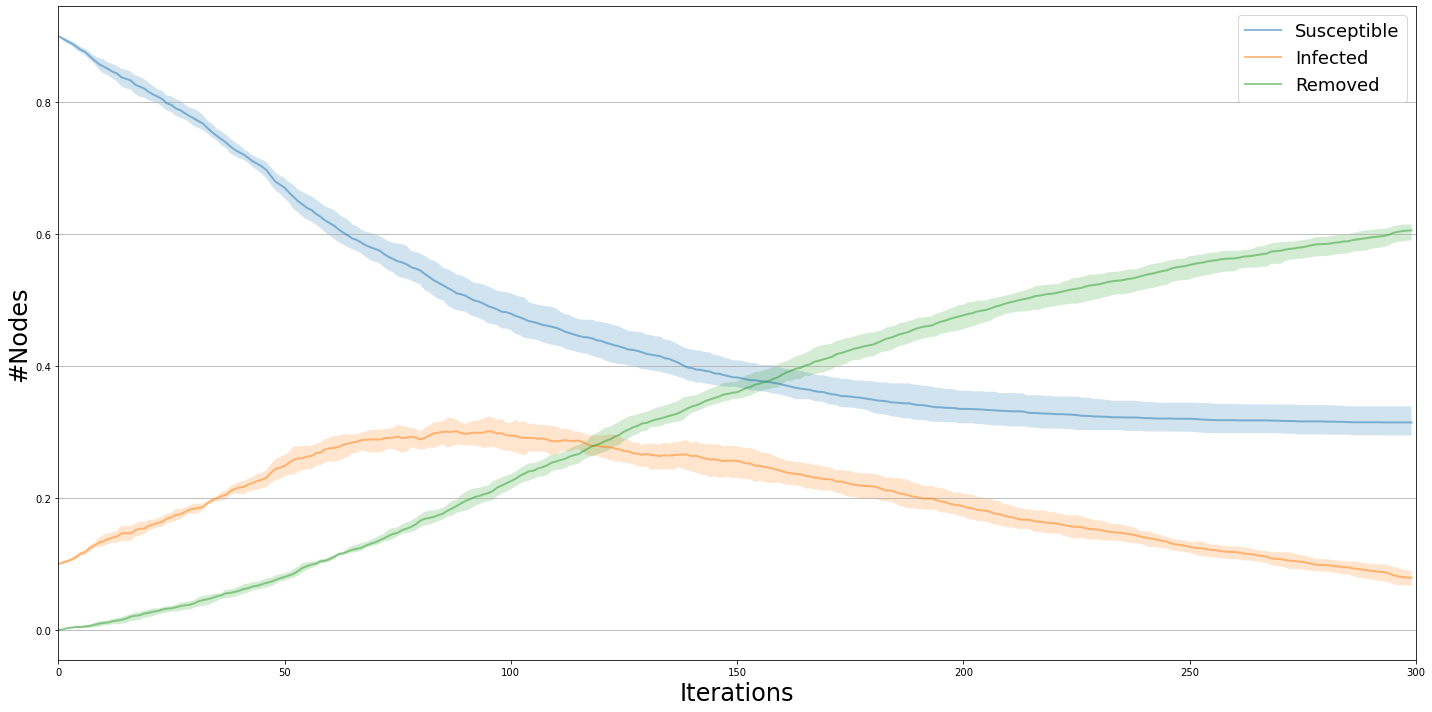

In [55]:
network_assc_results_analysers[7].plot_diff_trend()